In [1]:
%matplotlib notebook
import torch
import matplotlib.pyplot as plt
import schemes as sc

# Data type and device setup

In [2]:
dtype = torch.float
device = torch.device("cpu")

# Lorenz system

$\dot{x}=\sigma(y-x)$

$\dot{y}=x(\rho-z)-y$

$\dot{z}=xy-\beta z$

In [12]:
def Lorenz(xx,p):
    x, y, z = xx[0], xx[1], xx[2]
    σ, ρ, β =  p[0],  p[1],  p[2]
    return torch.tensor([ σ*(y-x), x*(ρ-z)-y, x*y-β*z])

<IPython.core.display.Javascript object>


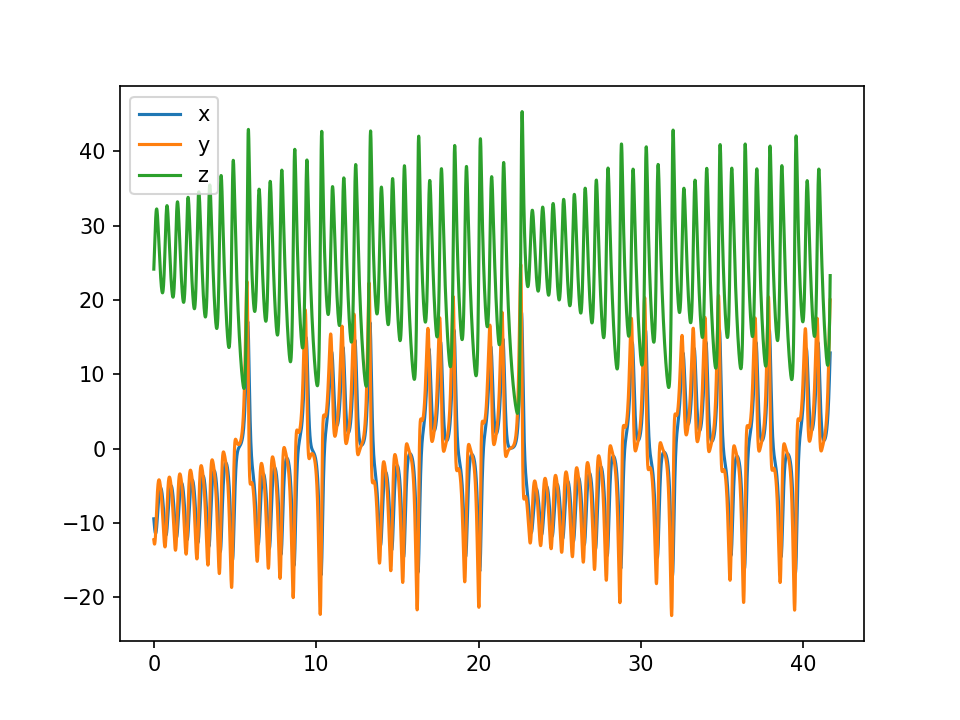

In [30]:
t_true = torch.linspace(0, 50, 6001)
x_3D = torch.tensor([1,1,1]).reshape(1,-1)
param  = [10, 28, 8/3] # [σ, ρ, β]

dt  = t_true[1] - t_true[0]
fun = lambda t,x: Lorenz(x,param)
for i in range(1, len(t_true)):
    x_3D = torch.cat([x_3D, sc.rk4(fun, t_true, x_3D[i-1,:], dt).reshape(1,-1)], 0)

t_true = t_true[0:5000]
x_3D   = x_3D[-len(t_true):,:]
    
fig = plt.figure()
axs = fig.add_subplot(1, 1, 1)
axs.plot(t_true, x_3D, label = ['x','y','z'])
plt.legend()
#plt.show()

<IPython.core.display.Javascript object>


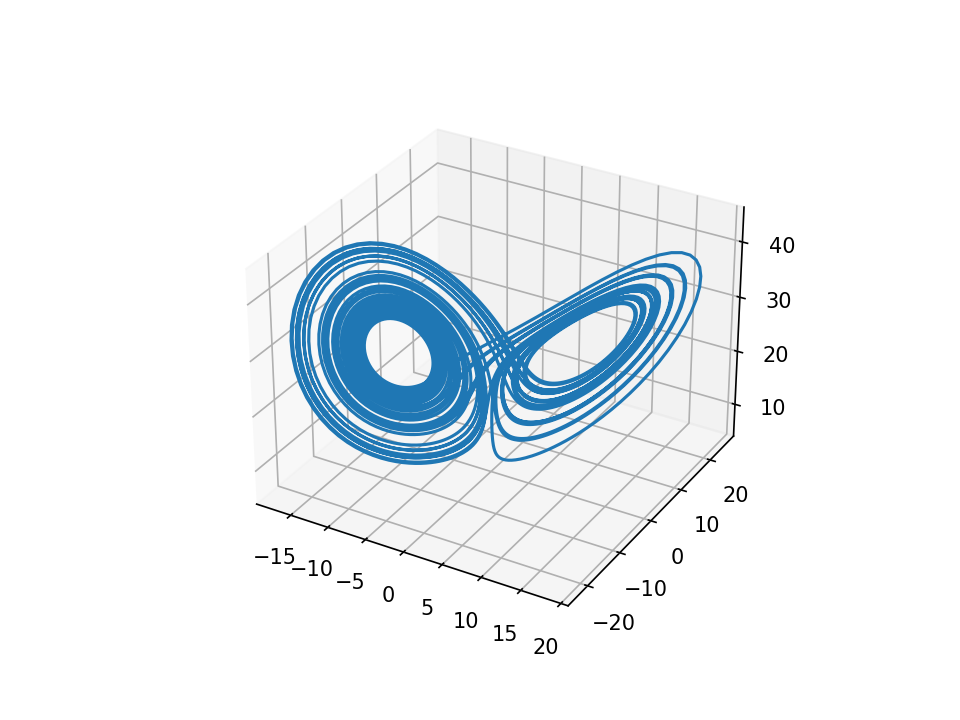

In [27]:
fig = plt.figure()
axs = fig.add_subplot(projection='3d')
axs.plot(x_3D[:,0], x_3D[:,1], x_3D[:,2])

In [31]:
x_true = x_3D[:,0]

In [32]:
dt = t_true[1] - t_true[0]
Nc = 100

<img src="./Figures/Model_1.png" alt="Model Outline" width="1000" height="1000">

# Model 

In [ ]:
def model(t, xx, w0):
    
    return torch.mm(xx, w0)

# Initialization

In [ ]:
τ = torch.tensor([0.2], device=device, dtype=dtype, requires_grad=True)
w0 = torch.zeros((2, 2), device=device, dtype=dtype, requires_grad=True)

lr_tau = 1e-4
lr_w0 = 1
batch_size = 20
batch_time = 10  # (x_true)-Nc
lr_pow_w0 = torch.linspace(0, -2, 100)
lr_pow_tau = torch.linspace(0, -4, 100)

loss_arr   = []
τ_arr      = []
τ_grad_arr = []

In [ ]:
fig = plt.figure()
axs = fig.add_subplot(1, 1, 1)
for kk in range(2000):

    # lr_w0 = 1e-4 + 1e-1 * torch.tanh(torch.tensor(kk/500))
    # lr_tau = 1e-1 * torch.tensor(10).pow(lr_pow_tau[kk//100])
    batch_time = 10 + ((kk // 100) * 10);

    if kk % 100 == 0:
        print('lr_w0=', lr_w0)
        print('batch_time=', batch_time)

    z_true = sc.interp_linear(t_true,x_true,Nc,τ)

    if kk % 100 == 0:
        st_id = torch.randint(0, len(z_true) - batch_time, (1,)).item()

    id_sel = torch.randint(0, z_true.shape[0] - batch_time, (batch_size,))
    z_true_stack = torch.stack([z_true[id_sel + i, :] for i in range(batch_time)], dim=0)
    t_true_stack = torch.stack([t_true[id_sel + i] for i in range(batch_time)], dim=0)
    # print(z_true_stack.shape)
    # print(t_true_stack.shape)

    for i in range(0, batch_time):
        fun = lambda t, x: model(t, x, w0)
        if i == 0:
            z_pred = z_true_stack[i, :, :].reshape(1, z_true_stack.shape[1], z_true_stack.shape[2])
        else:
            z_next = sc.rk4(fun, t_true[i], z_pred[i - 1, :, :], dt)
            z_pred = torch.cat([z_pred, z_next.reshape(1, z_true_stack.shape[1], z_true_stack.shape[2])], 0)

    # print("z_pred.shape=", z_pred.shape)
    # print("z_true.shape=",z_true[0:batch_time,:].shape)
    # loss = torch.abs((z_true[0:batch_time,:]-z_pred)).sum() + torch.abs(w0).sum()

    # loss = (z_true_stack-z_pred).pow(2).mean() #+ 1e-5* torch.abs(w0).sum()
    loss = torch.abs((z_true_stack - z_pred)).mean() + 1e-2 * torch.abs(w0).sum()
    loss.backward()

    with torch.no_grad():
        w0_old = w0.detach().numpy()
        τ_old = τ.detach().numpy()

        # print(τ_old)
        τ_arr.append(τ_old)
        τ_grad_arr.append(τ.grad.detach().numpy())
        # print(w0.grad)
        w0 -= lr_w0 * w0.grad
        if kk > 300:
            τ -= lr_tau * τ.grad * (10 * (kk % 10 == 0) + (kk % 10 != 0))

        loss_arr.append(loss.item())
        # print(loss.item())
        if kk % 10 == 0:
            # Visualize
            plt.cla()
            for p_id in range(batch_size):
                axs.plot(t_true_stack.detach().numpy()[:, p_id], z_pred[:, p_id, 0].detach().numpy(), 'ro')
                axs.plot(t_true_stack.detach().numpy()[:, p_id], z_pred[:, p_id, 1].detach().numpy(), 'bo')

            axs.plot(t_true[0:len(z_true)], z_true[:, 0].detach().numpy(), 'r-')
            axs.plot(t_true[0:len(z_true)], z_true[:, 1].detach().numpy(), 'b-')
            
            plt.show(block=False)

            fig.canvas.draw()
            plt.pause(0.0001)

        if kk % 25 == 0:
            print("iter=", kk)
            print("loss=", loss.detach().numpy())
            print("w0=", w0.detach().numpy())
            print("tau=", τ.detach().numpy())

        w0.grad = None
        τ.grad = None

In [35]:
pow_mat = torch.tensor(sc.get_pow_mat(dim=2, degree=2))

In [42]:
nc     = 100
τ_arr  = torch.tensor([0,dt*(nc//2)])
z_true = sc.interp_linear(t = t_true, x = x_true, nc= nc, τs=τ_arr)

In [43]:
z_true.shape

torch.Size([4900, 2])

In [41]:
τ_arr

tensor([0.4167])

In [50]:
zz = z_true.pow(pow_mat[0,:])

In [53]:
zzz = zz[:,0]
for i in range(1,zz.shape[1]):
    zzz *= zz[:,i]

In [54]:
zzz

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [ ]:
def get_feature_mat(x, degree):
    pow_mat = torch.tensor(sc.get_pow_mat(dim=x.shape[1], degree=degree))
    
    
    
    